# CF (with ALS)

### Initialization

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType,StructField, StringType, IntegerType,TimestampType

spark = SparkSession \
    .builder \
    .appName("Spark_Processor") \
    .master("local[*]") \
    .getOrCreate()

sc = spark.sparkContext

schema = StructType([ \
        StructField("DEVICE_CODE", IntegerType(), True), 
        StructField("SYSTEM_ID",IntegerType(),True), \
        StructField("ORIGINE_CAR_KEY",IntegerType(),True), \
        StructField("FINAL_CAR_KEY", IntegerType(),True), \
        StructField("CHECK_STATUS_KEY", IntegerType(), True), \
        StructField("COMPANY_ID", StringType(), True), \
        StructField("PASS_DAY_TIME", TimestampType(), True)
    ])

22/02/11 21:57:31 WARN Utils: Your hostname, amin-X556UQK resolves to a loopback address: 127.0.1.1; using 172.20.0.1 instead (on interface br-13093d199dae)
22/02/11 21:57:31 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/02/11 21:57:32 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/02/11 21:57:35 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/02/11 21:57:35 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [3]:
df = spark.read.csv('Traffic.csv',header=True,schema=schema)
df.show(1)

+-----------+---------+---------------+-------------+----------------+----------+-------------------+
|DEVICE_CODE|SYSTEM_ID|ORIGINE_CAR_KEY|FINAL_CAR_KEY|CHECK_STATUS_KEY|COMPANY_ID|      PASS_DAY_TIME|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+
|     200501|       81|       10477885|     10477885|               5|       161|2021-06-01 03:54:39|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+
only showing top 1 row



##### Remove 8th day

In [4]:
from pyspark.sql.functions import dayofyear
df = df.withColumn('day', dayofyear(df.PASS_DAY_TIME))
df = df.filter(df.day != 159)
df.show(1)

+-----------+---------+---------------+-------------+----------------+----------+-------------------+---+
|DEVICE_CODE|SYSTEM_ID|ORIGINE_CAR_KEY|FINAL_CAR_KEY|CHECK_STATUS_KEY|COMPANY_ID|      PASS_DAY_TIME|day|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+---+
|     200501|       81|       10477885|     10477885|               5|       161|2021-06-01 03:54:39|152|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+---+
only showing top 1 row



##### Remove Outliers

In [5]:
from pyspark.sql.functions import hour,dayofweek, count
from pyspark.sql.window import Window

window = Window.partitionBy('FINAL_CAR_KEY')
df_with_car_count = df.withColumn('count', count('FINAL_CAR_KEY').over(window))
df_cleaned = df_with_car_count.filter(df_with_car_count['count'] < 1000)
df_cleaned.show(5)

+-----------+---------+---------------+-------------+----------------+----------+-------------------+---+-----+
|DEVICE_CODE|SYSTEM_ID|ORIGINE_CAR_KEY|FINAL_CAR_KEY|CHECK_STATUS_KEY|COMPANY_ID|      PASS_DAY_TIME|day|count|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+---+-----+
|     803001|      102|        7631929|      7631929|               6|       161|2021-06-01 10:37:55|152|    1|
|   22010048|      284|        7631930|      7631930|               5|       161|2021-06-02 13:21:00|153|    1|
|     900158|      283|        7631979|      7631979|               5|       264|2021-06-06 12:30:50|157|    9|
|  100700881|      283|        7631979|      7631979|               5|       264|2021-06-06 17:46:08|157|    9|
|     900222|      283|        7631979|      7631979|               5|       264|2021-06-06 17:49:52|157|    9|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+---

<h5 dir="rtl">
 با اضافه کردن یک ستون زمان (که اندیس ساعت هفته است) و سپس 
 groupBy
  رو آن و دوربین، تعداد ترددها در هر ساعت از هفته برای هر دوربین را به دست می‌آوریم. 
</h5> 


In [6]:
camera_time_count = df_cleaned.withColumn('time', (dayofweek(df.PASS_DAY_TIME)-1)*24 + hour(df.PASS_DAY_TIME))
camera_time_count = camera_time_count.groupBy('DEVICE_CODE', 'time').count()
camera_time_count.show(5)

22/02/11 22:14:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/02/11 22:14:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


+-----------+----+-----+
|DEVICE_CODE|time|count|
+-----------+----+-----+
|     211401|  90|  352|
|     631350|  55|   77|
|     631349|  90|  101|
|        231|  41| 1712|
|   22009971| 151|  421|
+-----------+----+-----+
only showing top 5 rows



<h5 dir="rtl">
 در این قسمت با استفاده از الگوریتم 
 ALS
 و داده‌ها، مدلی را آموزش می‌دهیم تا بتوانیم روش
 CF
 را اجرا کنیم. برای این منظور داده‌ها را به دو دسته‌ی آموزش و آزمون تقسیم می‌کنیم. 
</h5> 


In [7]:
from pyspark.ml.recommendation import ALS

training, test = camera_time_count.randomSplit([0.8, 0.2])

als = ALS(
    maxIter = 5, 
    regParam = 0.01, 
    userCol = 'DEVICE_CODE', 
    itemCol = 'time', 
    ratingCol = 'count',
    coldStartStrategy= 'drop')

model = als.fit(training)

22/02/11 22:19:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/02/11 22:19:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/02/11 22:24:54 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/02/11 22:24:55 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


<h5 dir="rtl">
 حال مدل را روی داده‌ی تست اجرا می‌کنیم، و خطای مجذور میانگین مربعات را به دست می‌آوریم. 
</h5> 


In [7]:
from pyspark.ml.evaluation import RegressionEvaluator
predictions = model.transform(test)
predictions.show(5)
evaluator = RegressionEvaluator(
    metricName = 'rmse', 
    labelCol = 'count',
    predictionCol = 'prediction'
    )
rmse = evaluator.evaluate(predictions)
print('Root-mean-square error = ' + str(rmse))

<class 'pyspark.sql.dataframe.DataFrame'>


+-----------+----+-----+----------+
|DEVICE_CODE|time|count|prediction|
+-----------+----+-----+----------+
|        100|  68|  802|  704.4001|
|        100|  80|  782| 829.27893|
|        100|  97|   78|  71.76814|
|        100| 159|  425| 341.87933|
|        101|  63|   35| 53.008274|
+-----------+----+-----+----------+
only showing top 5 rows



Root-mean-square error = 93.20994499805558


<h5 dir="rtl">
 حال می‌توانیم برای هر دوربین، زمان‌هایی که بیشترین احتمال را دارد تا پلاکی را ثبت کند حدس بزنیم. همچنین برای هر زمان می‌توانیم دوربین‌هایی که بیشترین احتمال را دارند تا یک پلاک ثبت کنند را به دست آوریم. این کار را برای ۵ حدس اول در پایین برای تمام داده‌ها انجام دادم. 
</h5> 


In [8]:
user_recommendations = model.recommendForAllUsers(5)
movie_recommendations = model.recommendForAllItems(5)
user_recommendations.show()
movie_recommendations.show()

/home/amin/.local/share/virtualenvs/HW-QXNApxFg/lib/python3.9/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


+-----------+--------------------+
|DEVICE_CODE|     recommendations|
+-----------+--------------------+
|        101|[{41, 107.71721},...|
|        103|[{43, 311.4745}, ...|
|        108|[{55, 28.418291},...|
|        111|[{41, 13.435217},...|
|        115|[{55, 1009.5403},...|
|        120|[{43, 71.759415},...|
|        122|[{67, 13.433112},...|
|        126|[{43, 43.917404},...|
|        128|[{55, 767.94214},...|
|        137|[{66, 561.5732}, ...|
|        139|[{19, 125.07014},...|
|        140|[{31, 469.26434},...|
|        142|[{31, 1433.0504},...|
|        146|[{43, 71.21275}, ...|
|        148|[{19, 52.202732},...|
|        155|[{31, 1476.6473},...|
|        157|[{31, 139.28693},...|
|        163|[{19, 348.423}, {...|
|        164|[{19, 43.930725},...|
|        168|[{19, 351.68945},...|
+-----------+--------------------+
only showing top 20 rows



+----+--------------------+
|time|     recommendations|
+----+--------------------+
|   0|[{100700853, 1370...|
|   1|[{100700853, 944....|
|   2|[{900212, 493.161...|
|   3|[{900212, 546.741...|
|   4|[{900212, 500.363...|
|   5|[{900212, 741.163...|
|   6|[{900212, 1764.99...|
|   7|[{900212, 2319.26...|
|   8|[{900212, 2719.96...|
|   9|[{22010087, 3873....|
|  10|[{22010087, 4566....|
|  11|[{900244, 4652.20...|
|  12|[{900212, 4689.04...|
|  13|[{900212, 4588.52...|
|  14|[{900212, 4202.64...|
|  15|[{900244, 4430.94...|
|  16|[{900212, 4428.08...|
|  17|[{900212, 5238.94...|
|  18|[{900212, 5539.48...|
|  19|[{22010088, 6080....|
+----+--------------------+
only showing top 20 rows



<h5 dir="rtl">
 برای نمایش بهتر نتیجه‌ی الگوریتم، چند دوربین را به دلخواه انتخاب کردم و داده‌های تست را به آن‌ها محدود کردم. 
</h5> 


In [9]:
camera_subset = test.filter(df_cleaned.DEVICE_CODE < 105)
camera_subset.show(5)

22/02/11 22:30:41 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/02/11 22:30:42 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


+-----------+----+-----+
|DEVICE_CODE|time|count|
+-----------+----+-----+
|        100|   5|   37|
|        100|  22|  249|
|        100|  28|   45|
|        100|  78|  542|
|        100|  94|  282|
+-----------+----+-----+
only showing top 5 rows



<h5 dir="rtl">
 حال برای این چند دوربین خاص، به کمک مدل تعداد بار دیدن را حدس زدم. 
</h5> 


In [10]:
prediction_subset = model.transform(camera_subset)
prediction_subset.show(5)

22/02/11 22:36:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/02/11 22:36:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


+-----------+----+-----+----------+
|DEVICE_CODE|time|count|prediction|
+-----------+----+-----+----------+
|        100|   5|   37| 41.745083|
|        100|  22|  249|  308.1902|
|        100|  28|   45|  42.10656|
|        100|  78|  542|  488.1757|
|        100|  94|  282| 268.71606|
+-----------+----+-----+----------+
only showing top 5 rows



<h5 dir="rtl">
 حال خروجی را به صورتی دراوردم که قابل نمایش باشد.  
</h5> 


In [11]:
def convert_to_vector(data_list):
    real = [0]*24*7
    predicted = [0]*24*7
    for time, count, prediction in data_list:
        real[time] = count
        predicted[time] = prediction

    return (real, predicted)

camera_predictions = prediction_subset.rdd.map(lambda x: (x.DEVICE_CODE, (
    x.time,
    x['count'],
    x['prediction']
))).groupByKey().mapValues(convert_to_vector).collect()

22/02/11 22:41:50 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/02/11 22:41:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


<h5 dir="rtl">
 در این مرحله نیز نتایج را برای این چند دوربین خاص رسم کردم. خطوط قرمز رنگ مقادیر واقعی هستند و خطوط سیاه مقادیر پیش‌بینی شده. همانطوری که می‌بینید الگوریتم به خوبی توانسته است در زمان‌هایی که داده نداشته است، تعداد ثبت پلاک‌ها برای هر دوربین را پیش‌بینی کند. 
</h5> 


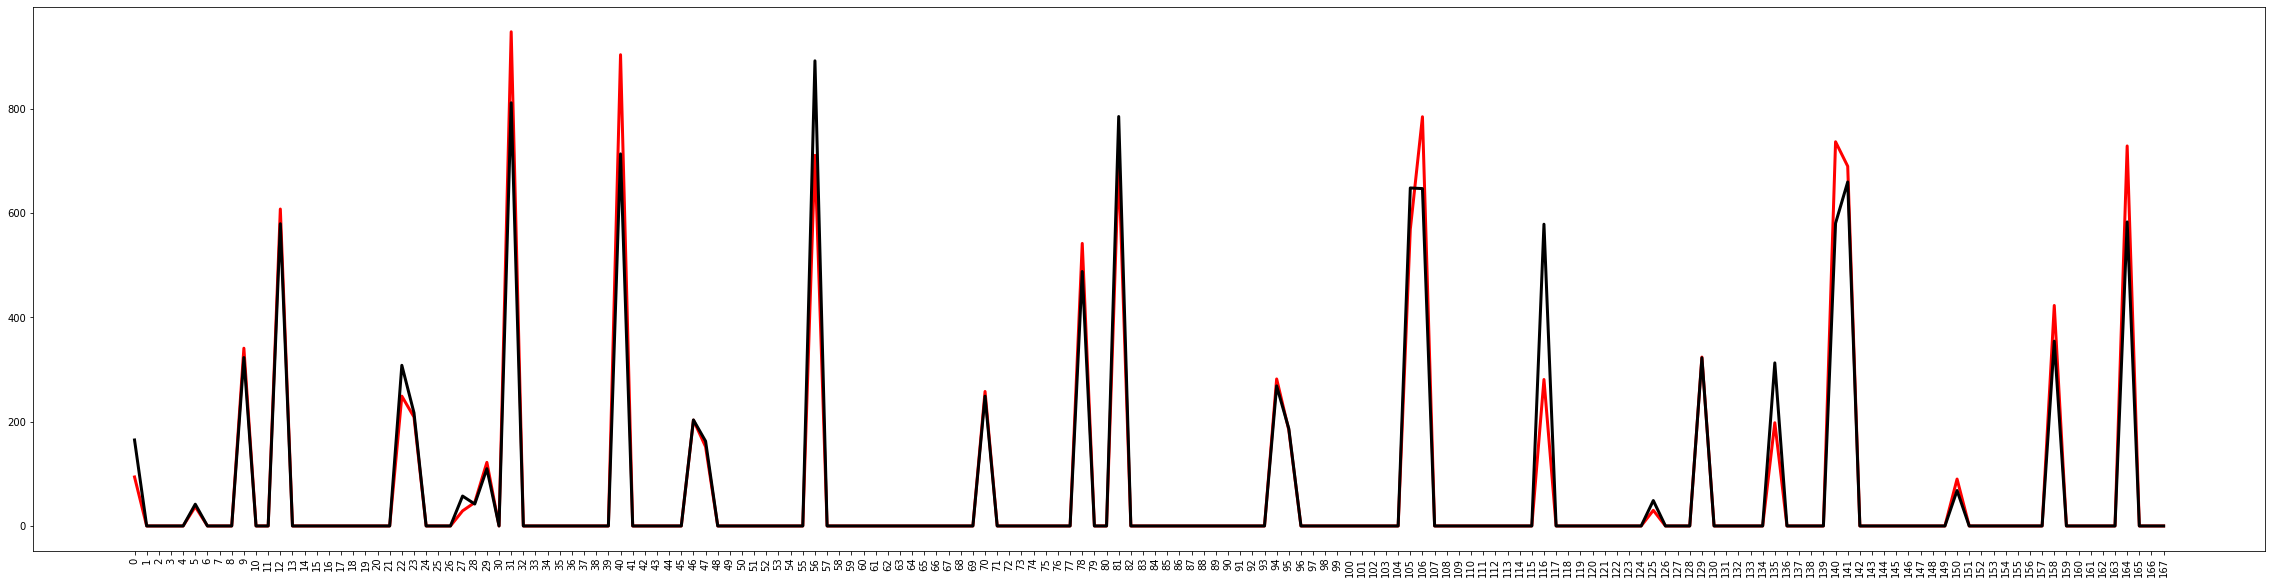

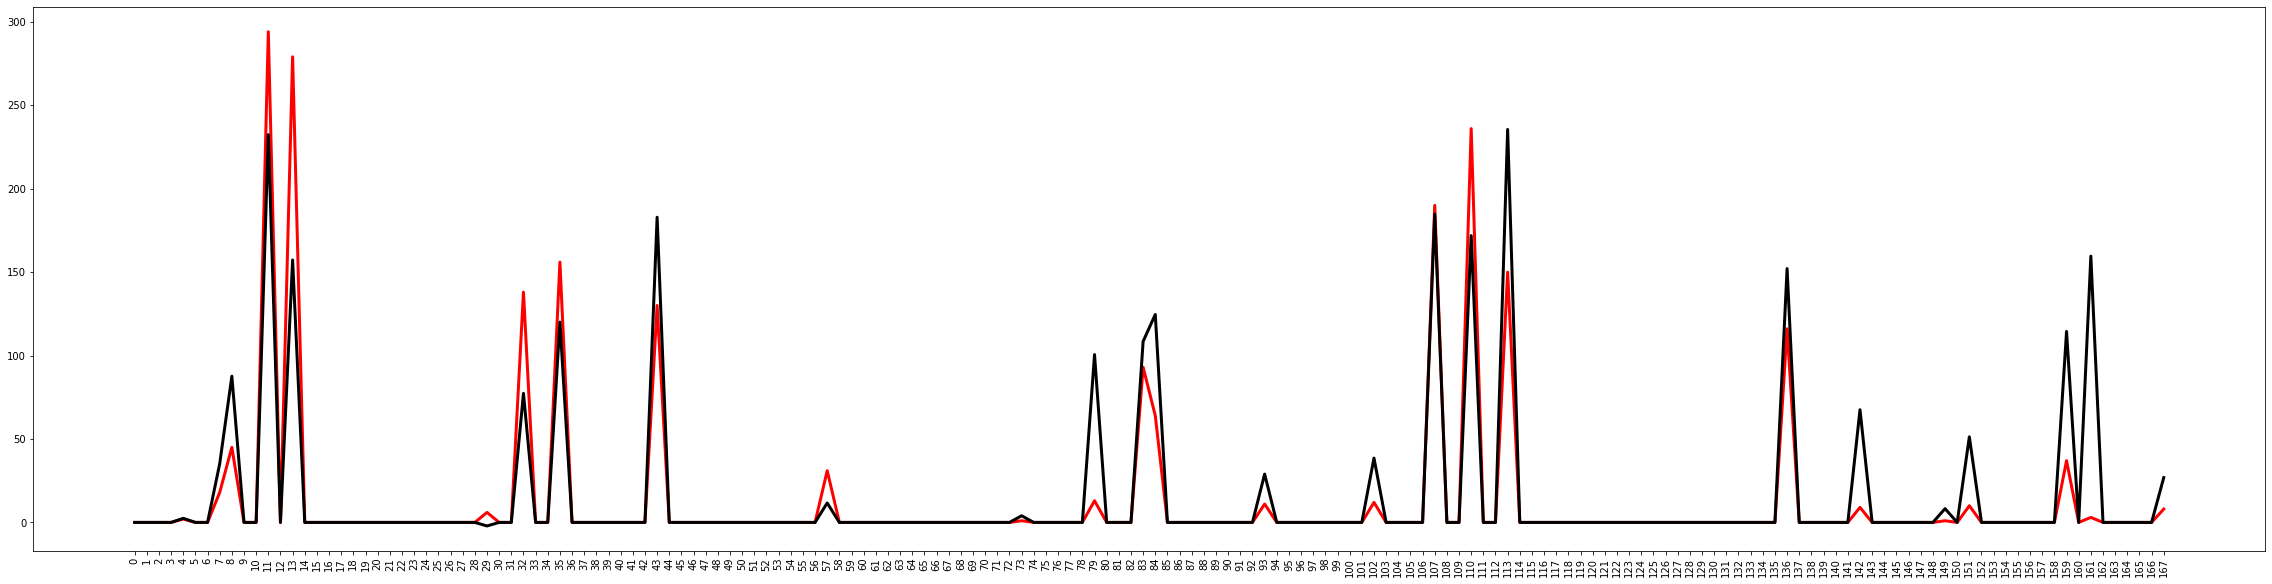

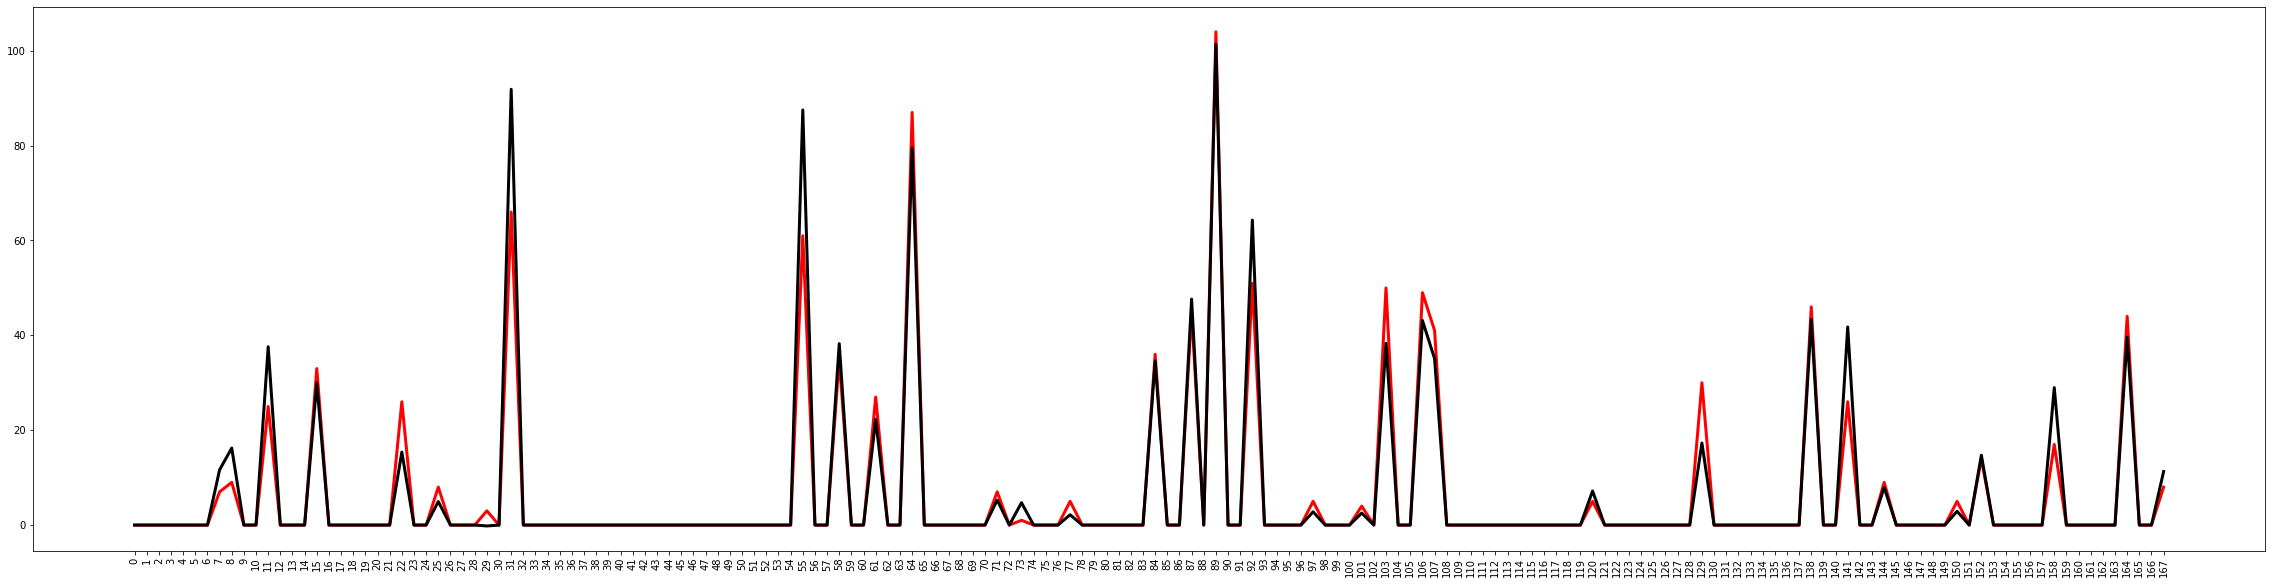

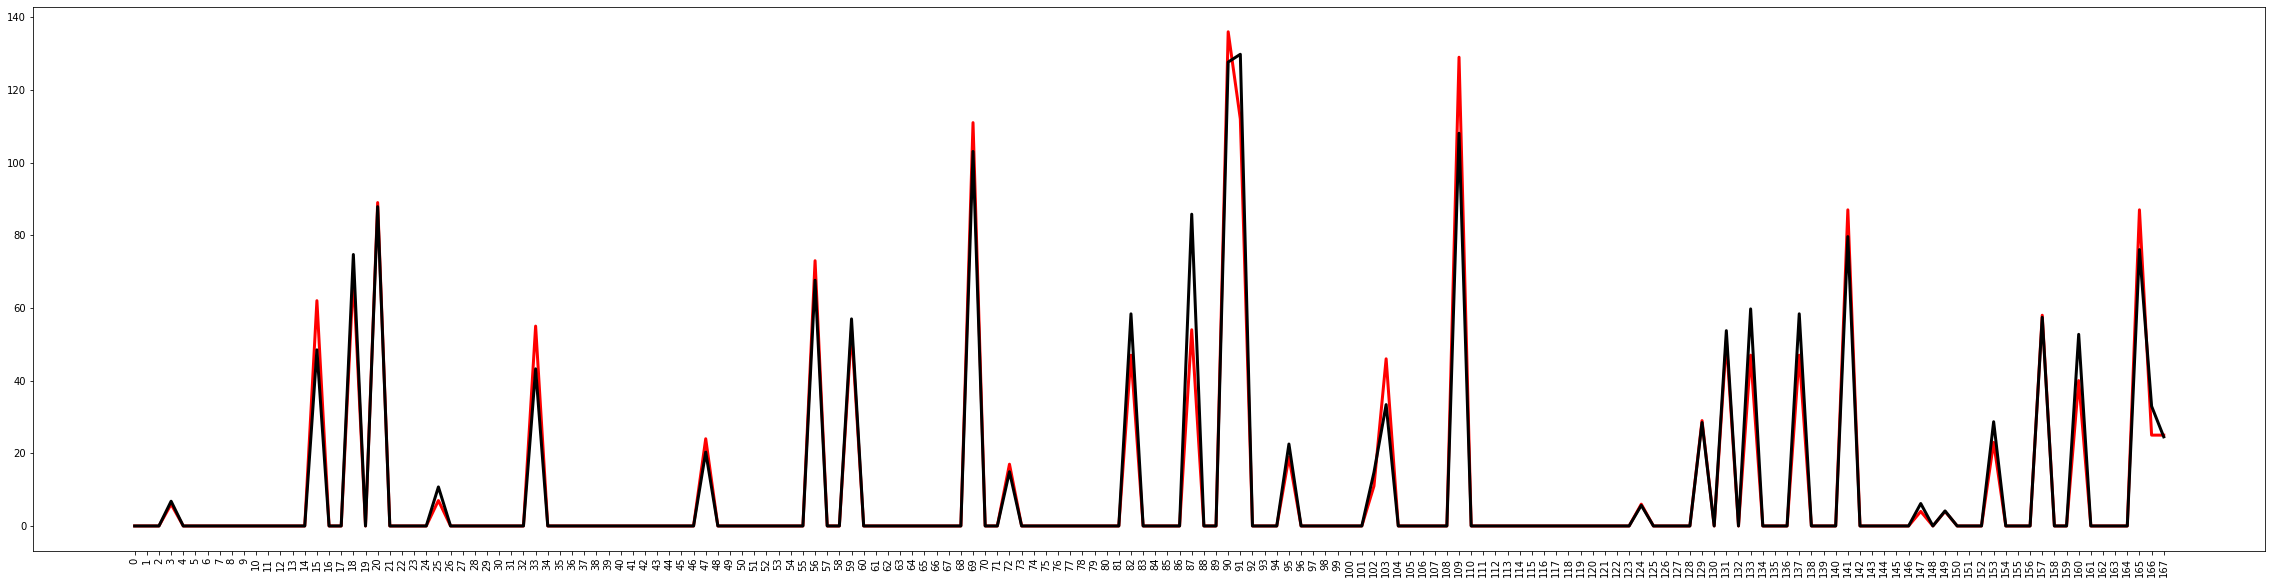

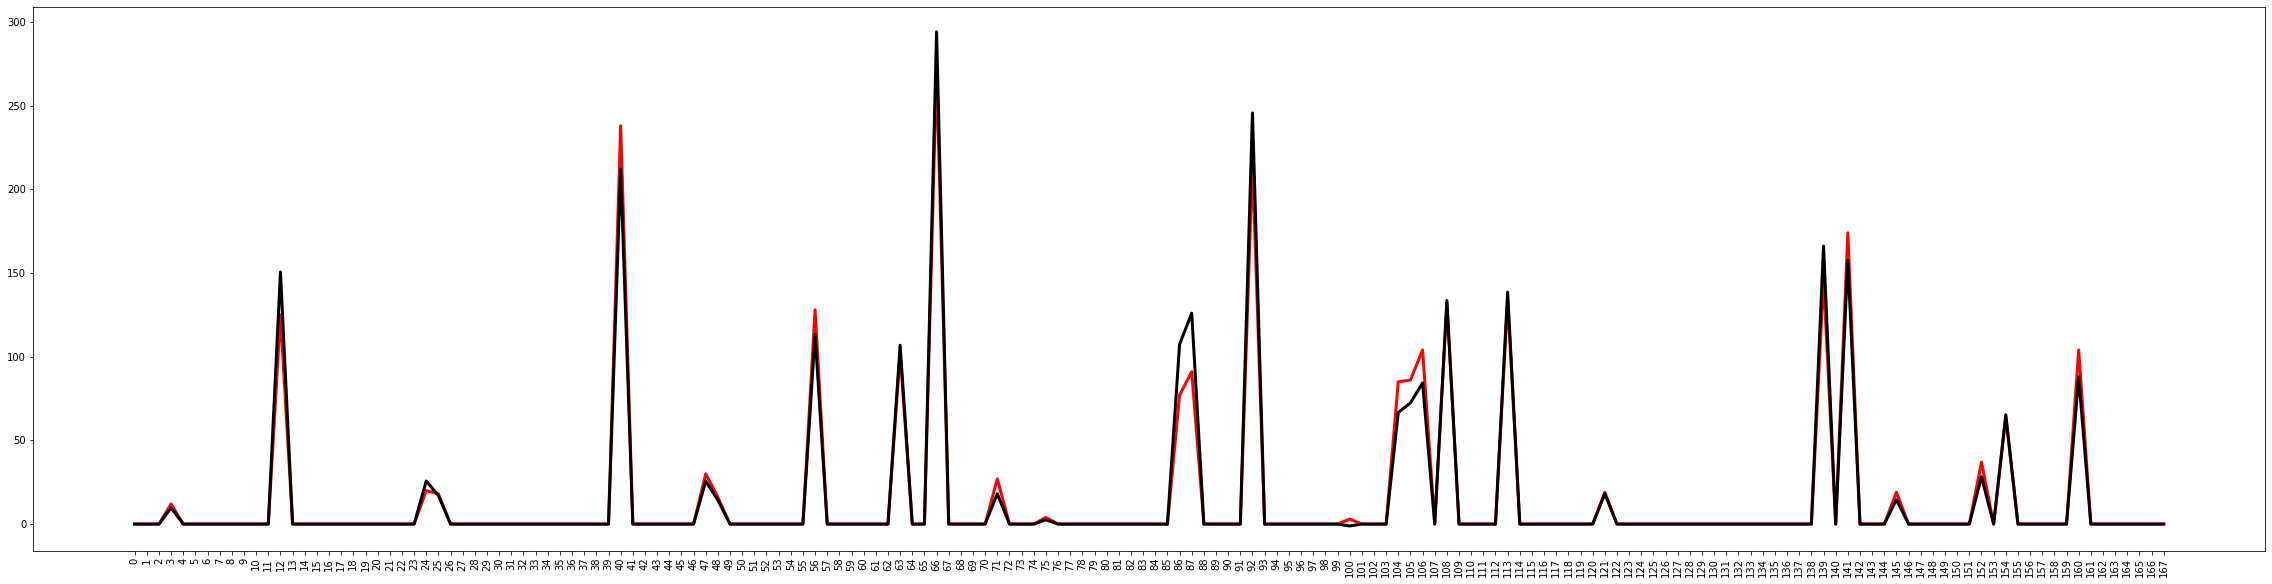

In [12]:
from matplotlib import pyplot as plt

for camera, (real_counts, predicted_counts) in camera_predictions:
    fig = plt.figure(figsize = (40, 10))
    labels = list(map(lambda x: str(x), range(24*7)))
    plt.plot(labels, real_counts, linewidth=3, color='red')
    plt.plot(labels, predicted_counts, linewidth=3, color='black')
    plt.xticks(rotation='vertical',fontsize=10)
    plt.show()